In [7]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt

In [ ]:
"""import kagglehub

# Download latest version
path = kagglehub.dataset_download("phucthaiv02/butterfly-image-classification")

print("Path to dataset files:", path)"""

In [11]:
train_ds = keras.utils.image_dataset_from_directory(
    r'C:\Users\pedro.quinet\Desktop\IC-UFRJ-Zanini\transfer_learning_reference_2\treino',
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    validation_split=0.1,
    subset="training",
    seed = 123)

validation_ds = keras.utils.image_dataset_from_directory(
    r'C:\Users\pedro.quinet\Desktop\IC-UFRJ-Zanini\transfer_learning_reference_2\treino',
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    validation_split=0.1,
    subset="validation",
    seed = 123)

Found 6499 files belonging to 75 classes.
Using 5850 files for training.
Found 6499 files belonging to 75 classes.
Using 649 files for validation.


In [ ]:
# Em bachts de 32
print(f"Number of training samples: {train_ds.cardinality()}")
print(f"Number of validation samples: {validation_ds.cardinality()}")


Number of training samples: 183
Number of validation samples: 21


In [23]:
resize_fn = keras.layers.Resizing(150, 150)

train_ds = train_ds.map(lambda x, y: (resize_fn(x), y))
validation_ds = validation_ds.map(lambda x, y: (resize_fn(x), y))


In [24]:
augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(x):
    for layer in augmentation_layers:
        x = layer(x)
    return x


train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

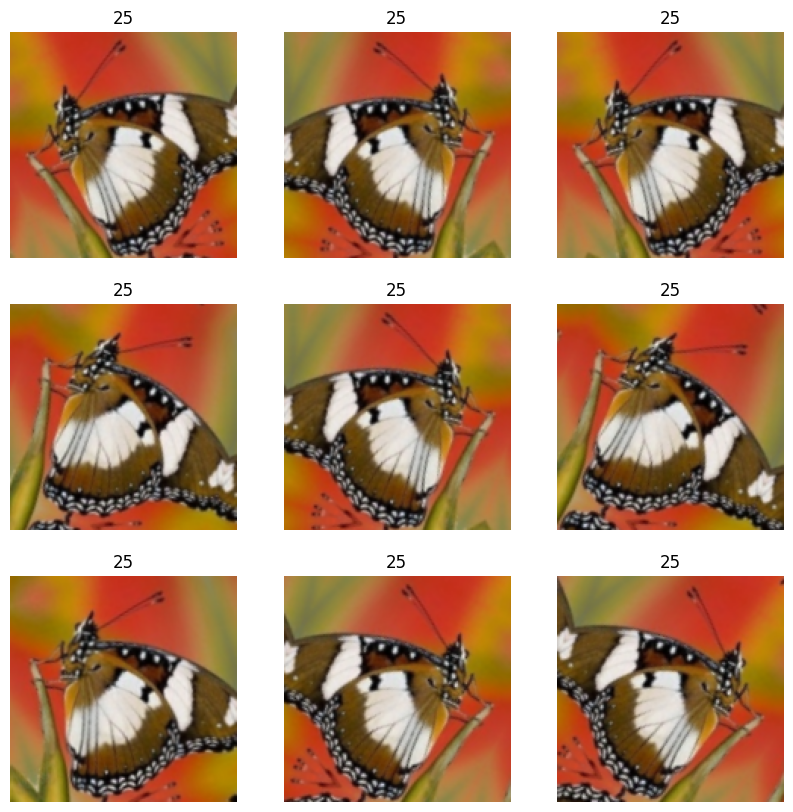

In [25]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(np.expand_dims(first_image, 0))
        plt.imshow(np.array(augmented_image[0]).astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")

In [ ]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,  # Do not include the ImageNet classifier at the top.
)

# Freeze the base_model so its weights aren't updated during initial training.
base_model.trainable = False

# --- Building the New Classifier Head ---
# Define the model's input.
inputs = keras.Input(shape=(150, 150, 3))

# Pre-trained Xception weights require that input be scaled
# from (0, 255) to a range of (-1., +1.).
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)

x = base_model(x, training=False)

# Add custom layers on top of the base model's output.
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout

outputs = keras.layers.Dense(75, activation="softmax")(x)

# Create the final model.
model = keras.Model(inputs, outputs)

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)


model.summary(show_trainable=True)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_1 (InputLayer)  │ (None, 150, 150, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ rescaling (Rescaling)       │ (None, 150, 150, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ xception (Functional)       │ (None, 5, 5, 2048)    │ 20,861,480 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d    │ (None, 2048)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout (Dropout)           │ (None, 2048)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense (Dense)               │ (None, 75)            │    153,675 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 21,015,155 (80.17 MB)

 Trainable params: 153,675 (600.29 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [27]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

epochs = 20
print("Fitting the top layer of the model")
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Fitting the top layer of the model
Epoch 1/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 152s 814ms/step - accuracy: 0.3542 - loss: 2.8071 - val_accuracy: 0.7149 - val_loss: 1.0099
Epoch 2/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 141s 769ms/step - accuracy: 0.7362 - loss: 0.9632 - val_accuracy: 0.7797 - val_loss: 0.8054
Epoch 3/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 142s 774ms/step - accuracy: 0.7957 - loss: 0.7248 - val_accuracy: 0.7689 - val_loss: 0.7418
Epoch 4/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 147s 800ms/step - accuracy: 0.8365 - loss: 0.5967 - val_accuracy: 0.8012 - val_loss: 0.6727
Epoch 5/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 144s 785ms/step - accuracy: 0.8502 - loss: 0.5200 - val_accuracy: 0.8105 - val_loss: 0.6220
Epoch 6/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 153s 836ms/step - accuracy: 0.8737 - loss: 0.4673 - val_accuracy: 0.8043 - val_loss: 0.6402
Epoch 7/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 148s 806ms/step - accuracy: 0.8779 - loss: 0.4276 - val_accuracy: 0.8151 - val_loss: 0.5873
Epoch 8/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 1

In [ ]:
base_model.trainable = True
model.summary(show_trainable=True)

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

epochs = 3
print("Fitting the end-to-end model")
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

In [29]:
# Os dados de teste não tem labels :-()

print("Validation dataset evaluation")
model.evaluate(validation_ds)

Validation dataset evaluation
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 583ms/step - accuracy: 0.8321 - loss: 0.5926


[0.5900506973266602, 0.8305084705352783]

In [31]:
model.save(r'C:\Users\pedro.quinet\Desktop\IC-UFRJ-Zanini\transfer_learning_reference_2\model_weights.keras')